## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial
from path_sampling import dfdt, div_f, update, update_non_amortized


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(400)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Example of a path in a double well

Here's an example of sampling a path in a double well potential.

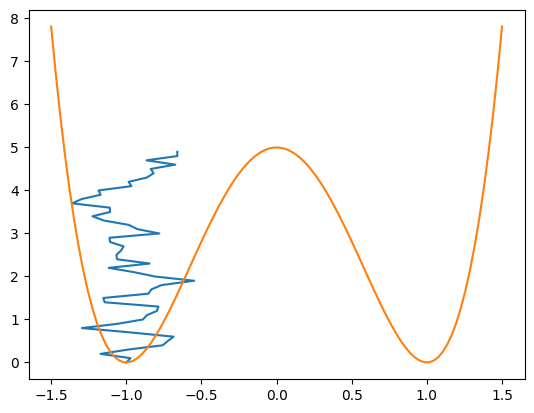

In [3]:
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 200}


potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    # potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
    return -jax.grad(potential)(x)

path, time = sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=jax.random.key(0), 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps'])

# visualize path
plt.plot(path,time*10)
# plot potential
x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, potential(x[:, None]))

## Brownian motion prior, brownian bridge posterior

sorry about the background double well - just there by default - there's no double well potential in this example!

Schedule: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
s:  0.0
Train loss: 190740.0
Test loss is 202280.375
s:  0.1
Train loss: 55280.51171875
Test loss is 54671.59765625
s:  0.2
Train loss: 12935.439453125
Test loss is 13627.61328125
s:  0.3
Train loss: 2199.8203125
Test loss is 2225.938232421875
s:  0.4
Train loss: 76.23548889160156
Test loss is 75.57117462158203
s:  0.5
Train loss: 0.00022775959223508835
Test loss is 0.0002596010162960738
s:  0.6
Train loss: 27.659971237182617
Test loss is 26.688701629638672
s:  0.7
Train loss: 353.3194580078125
Test loss is 368.16925048828125
s:  0.8
Train loss: 2371.47900390625
Test loss is 2418.50390625
s:  0.9
Train loss: 9087.482421875
Test loss is 9414.1962890625


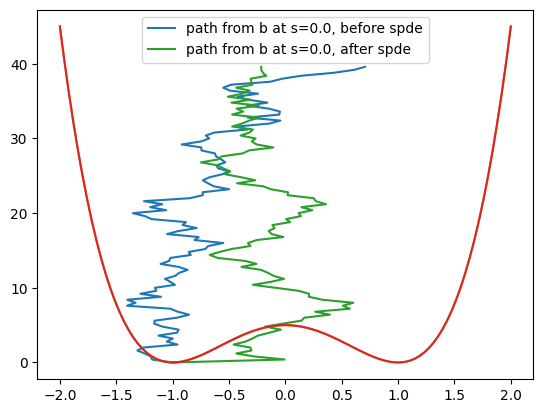

In [4]:
key = jax.random.key(0)
# schedule = np.linspace(0,1, 5)
schedule = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # obviously should be extended to 1, but just to see early steps...
print("Schedule:", schedule)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 200, 'batch_size' : 400}

b = lambda x, t: 0.0
A = 0
dbds = MLP([3,25,25,1], key=jax.random.key(1))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # I consider the version where only one NN is learned in total. The alternative version where a different NN is trained for each s is commented out below
    
    b, A = update_non_amortized(
        V=lambda x: 0.0,
        b=b,
        J=lambda x,y: (1/(2*(0.1**2)))*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        refine=True
    )
    
#     dbds, A = update(
#         V=lambda x: 0.0,
#         uref=b,
#         J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
#         dbds=dbds,
#         hyperparams=hyperparams,
#         key=key,
#         schedule=schedule,
#         i=i,
#         prior='sde_prior',
#         A=A,
#         refine=True
#     )


## Now use the learned b to generate new paths

In [28]:
from path_sampling import make_b

# if using the version with a single NN then comment out line below
# b = make_b(schedule, uref, dbds)

path_key, model_key, refine_key = jax.random.split(key, 3)

W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
xs, times = jax.pmap(lambda key:sample_sde(
b=b, 
W = W,
rho =  lambda key: jnp.zeros((ndims,))-1,
key=key, 
dt=hyperparams['dt'], 
num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 100))

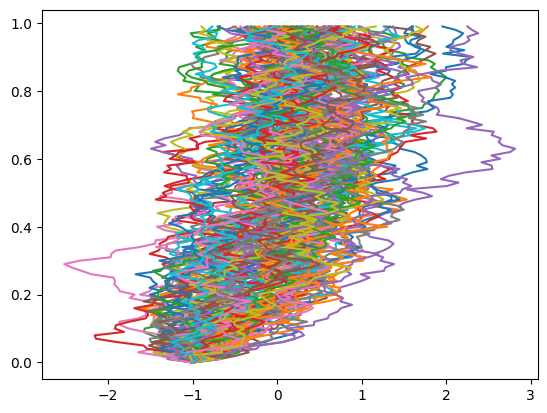

In [29]:
for path in xs:
    plt.plot(path, times[0])

# and compare to exact brownian bridge

(ignore the double well in the background - just a plotting artifact)

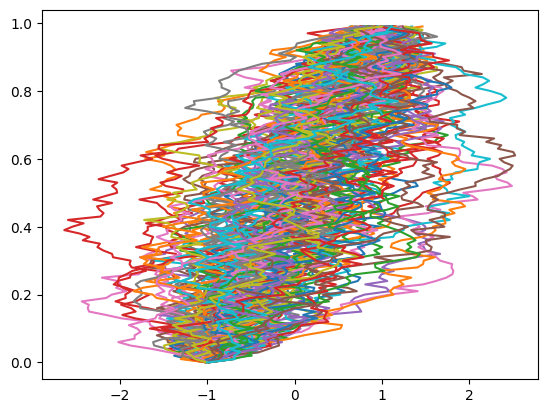

In [22]:
# estimate marginals
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}


true_paths, times = jax.pmap(lambda k: sample_sde(
    b= lambda x,t: (1 - x)/(1-t), 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=k, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(key, 100))

# visualize path
for path, time in zip(true_paths, times):
    plt.plot(path,time)
# plot potential
x = np.linspace(-1.5, 1.5, 100)


In [30]:
def metric(true_paths, learned_paths):
    print(learned_paths.shape)
    path_length = true_paths.shape[1]
    assert path_length == learned_paths.shape[1]
    true_path_mean = jnp.mean(true_paths, axis=0)
    true_path_std = jnp.std(true_paths, axis=0)
    print(true_path_mean.shape)
    print(true_path_std.shape)
    learned_path_mean = jnp.mean(learned_paths, axis=0)
    learned_path_std = jnp.std(learned_paths, axis=0)
    print(learned_path_mean.shape)
    print(learned_path_std.shape)
    self_dot = lambda x : jnp.dot(x,x)
    return jnp.sqrt((1/path_length)*jnp.sum(jax.vmap(lambda tm, ts, lm, ls : self_dot(tm - lm)+self_dot(ts-ls))(true_path_mean, true_path_std, learned_path_mean, learned_path_std)))
    
    # (self_dot(true_path_mean - learned_path_mean) + self_dot(true_path_std - learned_path_std)  ))




metric(true_paths=true_paths, learned_paths=xs)

(100, 100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)


Array(0.26652923, dtype=float32)